In [2]:
import os
import pandas as pd
import librosa
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
def pre_process_audio(path, surface):
    dfs = list()
    wav_list = []
    stft_list = []
    activity_list = []
    folder_list = []
    start_time = 20
    end_time = 55
    N_FFT = 2048
    HOP_SIZE = 1024
    dfs = list()
    dict_types = {'time':'float', 'dt':'float', 'x':'float', 'y':'float', 'z':'float'}

    for root, dirs, files in os.walk(path, topdown=False):
        for name in files:
            #if name == 'Accelerometer.csv':
            #    acc_path = os.path.join(root, name) 
            #    data = pd.read_csv(acc_path, names=['time', 'dt', 'z', 'y', 'x'], skiprows=[0], header=None, dtype = dict_types)
            #    folder = acc_path.split('/')[1]
            #    data['activity'] = folder.split('-')[0]
            #    data['folder'] = folder
            #    dfs.append(data)
            if name == 'Microphone.caf':
                mic_path = os.path.join(root, name)    
                wav_data, sr = librosa.load(mic_path, sr=None, mono=True)
                stft = librosa.amplitude_to_db(np.abs(librosa.stft(wav_data[start_time*sr:end_time*sr], n_fft=N_FFT, hop_length=HOP_SIZE, win_length=N_FFT,
                                                                        window='hann', center=True, pad_mode='constant' )), ref=np.max)
                folder = mic_path.split('/')[1]
                folder_list.append(folder)
                activity_list.append(folder.split('-')[0])
                wav_list.append(wav_data[sr*start_time:sr*end_time])
                stft_list.append(stft)
                #data['stft'] = stft

    #df = pd.concat(dfs, ignore_index=True)

    df = pd.DataFrame()
    df['activity'] = activity_list
    df['folder'] = folder_list
    df['wav_data'] = wav_list
    df['stft'] = stft_list
    
    # surface from which data came
    if surface=='table': 
        df = df[df.activity.str.contains('table')]
    elif surface=='free':
        df = df[df.activity.str.contains('lap') | df.activity.str.contains('free') | df.activity.str.contains('standing')]
    elif surface == 'x': # x for don't care
        # regroup activities 
        df['activity'] = df.activity.str.replace(r'_free$', '')
        df['activity'] = df.activity.str.replace(r'_lap$', '')
        df['activity'] = df.activity.str.replace(r'_table$', '')
        df['activity'] = df.activity.str.replace(r'_standing$', '')

    # save off specific holding and swiping activities
    df_hold = df[df.activity.str.contains('hold')]
    df_swipe = df[df.activity.str.contains('swipe')]

    # group holding activities
    df['activity'] = df.activity.str.replace(r'landscape_hold', 'hold')
    df['activity'] = df.activity.str.replace(r'portrait_hold', 'hold')

    # group tapping activities
    df['activity'] = df.activity.str.replace(r'tap_portrait', 'tap')

    # group swiping activities
    df['activity'] = df.activity.str.replace(r'swipe_lr', 'swipe')
    df['activity'] = df.activity.str.replace(r'swipe_rl', 'swipe')
        
    # drop holding activities
    df = df[~df['activity'].str.contains('hold')]
    df = df[~df['activity'].str.contains('call')]

    df = df[~df['activity'].str.contains('swipe')]


    return df


In [4]:
def extract_features(df):
    #X = pd.DataFrame()
    y = df['activity']
    X = np.asarray(df['stft'])
    for i in range(0, X.shape[0]):
        X[i] = X[i].flatten()
    X = np.vstack(X)
    return (X,y)

Random forest classifier: 
mean precision: 0.08333333333333333 mean recall: 0.5 mean F1 score: 0.14285714285714285 


/Users/az8797/miniforge3/envs/tensorflow-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


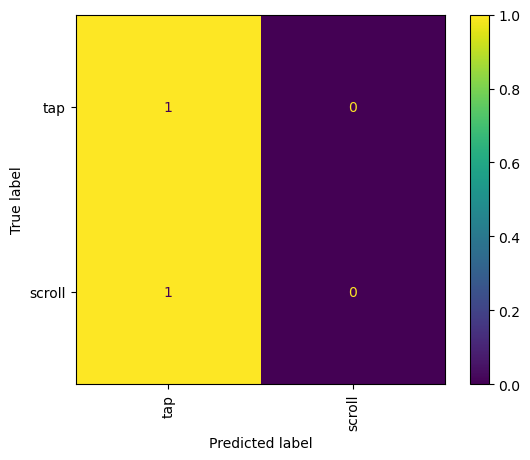

In [6]:
path = 'sensor_logger/'
df = pre_process_audio(path, surface='x')

folders_list = df['folder'].unique()
# randomly select 10 folders for testing
test_n = 6
test_indices = np.random.choice(len(folders_list), test_n, replace=False)

test_folders=[]
for i in test_indices:
    test_folders.append(folders_list[i])
test_df = df[df['folder'].isin(test_folders)]
X_test, y_test = extract_features(test_df)

train_df = df[~df['folder'].isin(test_folders)]
X_train, y_train = extract_features(train_df)

rf = RandomForestClassifier(n_estimators=40)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1_scores = f1_score(y_test, y_pred, average='macro')

print("Random forest classifier: ")
print("mean precision: {precision} mean recall: {recall} mean F1 score: {f1} ".format(recall=np.mean(recall), precision=np.mean(precision), f1=np.mean(f1_scores)))

# plot confusion matrix
labels = set(y_test).union(set(y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.yticks(rotation='horizontal')
plt.xticks(rotation='vertical')
plt.show()